# Models - GRU and LSTM (JR_01)

In [1]:
import pandas as pd
import numpy as np
from keras.layers import Dense, GRU, Input, LSTM
from keras.losses import Huber, MeanSquaredError
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# loading dataset
wkdir = '../data/raw/'

# df_errors = pd.read_csv(wkdir + 'PdM_errors.csv', parse_dates=['datetime'])
df_failures = pd.read_csv(wkdir + 'PdM_failures.csv', parse_dates=['datetime'])
df_machines = pd.read_csv(wkdir + 'PdM_machines.csv')
df_maint = pd.read_csv(wkdir + 'PdM_maint.csv', parse_dates=['datetime'])
df_telemetry = pd.read_csv(wkdir + 'PdM_telemetry.csv', parse_dates=['datetime'])

In [3]:
df_telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [4]:
# A total of 876100 rows (telemetry)

In [5]:
# Create dummies
# df_err = pd.get_dummies(df_errors, columns = ['errorID'], dtype=int, prefix='', prefix_sep='').groupby(['datetime','machineID']).sum().reset_index()
df_fail = pd.get_dummies(df_failures, columns = ['failure'], dtype=int, prefix='fail').groupby(['machineID','datetime']).sum().reset_index()
df_mnt = pd.get_dummies(df_maint, columns = ['comp'], dtype=int, prefix='maint').groupby(['machineID','datetime']).sum().reset_index()

In [6]:
# transform values to numbers
# df_failures['failure'] = df_failures['failure'].str.removeprefix('comp').astype(int)
df_machines['model'] = df_machines['model'].str.removeprefix('model').astype(int)
# df_machines['age'] = df_machines['age'].astype(np.float32)

In [7]:
# merging dataset
# merge all dfs into one.
# df_tele_err = pd.merge(df_telemetry, df_err, how='left', on=['datetime', 'machineID'])
df_tele_fail = pd.merge(df_telemetry, df_fail, how='left', on=['datetime', 'machineID'])
df_tele_fail_maint = pd.merge(df_tele_fail, df_mnt, how='left', on=['datetime', 'machineID'])
df_all = pd.merge(df_tele_fail_maint, df_machines, how='left', on="machineID")


In [8]:
print(df_all.head())

             datetime  machineID        volt  ...  maint_comp4  model  age
0 2015-01-01 06:00:00          1  176.217853  ...          NaN      3   18
1 2015-01-01 07:00:00          1  162.879223  ...          NaN      3   18
2 2015-01-01 08:00:00          1  170.989902  ...          NaN      3   18
3 2015-01-01 09:00:00          1  162.462833  ...          NaN      3   18
4 2015-01-01 10:00:00          1  157.610021  ...          NaN      3   18

[5 rows x 16 columns]


In [9]:
# replace NaN with 0
df_all.iloc[:,6:14] = df_all.iloc[:,6:14].fillna(0).astype(int)

In [10]:
# Flags for Failures and Maintenance
# df_all['error_flag'] = np.where(df_all[['error1', 'error2', 'error3', 'error4', 'error5']].sum(axis=1) == 0, 0, 1)
df_all['maint_flag'] = np.where(df_all[['maint_comp1', 'maint_comp2', 'maint_comp3', 'maint_comp4']].sum(axis=1) == 0, 0, 1)        #.astype(np.float32)
df_all['fail_flag'] = np.where(df_all[['fail_comp1', 'fail_comp2', 'fail_comp3', 'fail_comp4']].sum(axis=1) == 0, 0, 1)     #.astype(np.float32)

In [11]:
# remove columns
df = df_all.drop(columns=['fail_comp1', 'fail_comp2', 'fail_comp3', 'fail_comp4', 'maint_comp1', 'maint_comp2', 'maint_comp3', 'maint_comp4'])
# print(df.head())

In [12]:
# Train set first=0, last=582599
# Validation set first=582600, last=728999
# Test set first=729000, last=875399

In [13]:
df = df.sort_values(by=['datetime', 'machineID']).reset_index().drop(columns='index')

In [14]:
print(df.head())

             datetime  machineID        volt  ...  age  maint_flag  fail_flag
0 2015-01-01 06:00:00          1  176.217853  ...   18           0          0
1 2015-01-01 06:00:00          2  176.558913  ...    7           0          0
2 2015-01-01 06:00:00          3  185.482043  ...    8           0          0
3 2015-01-01 06:00:00          4  169.710847  ...    7           0          0
4 2015-01-01 06:00:00          5  165.082899  ...    2           0          0

[5 rows x 10 columns]


In [15]:
# Train, Validation and Test sets
start_val = 582600      # index for first validation set row
start_test = 729000      # index for first test set row
end_test = 875400

train_df = df[:start_val]
val_df = df[start_val:start_test]
# full_train_df = df[:start_test]
test_df = df[start_test:end_test]

In [16]:
# Sort by MachineID and datetime to get the whole time-series for each machine
train_df = train_df.sort_values(by=['machineID', 'datetime']).reset_index().drop(columns='index')
val_df = val_df.sort_values(by=['machineID', 'datetime']).reset_index().drop(columns='index')
test_df = test_df.sort_values(by=['machineID', 'datetime']).reset_index().drop(columns='index')

In [17]:
print(train_df.head(3))
print(train_df.tail(3))
print(val_df.head(3))
print(val_df.tail(3))
print(test_df.head(3))

             datetime  machineID        volt  ...  age  maint_flag  fail_flag
0 2015-01-01 06:00:00          1  176.217853  ...   18           0          0
1 2015-01-01 07:00:00          1  162.879223  ...   18           0          0
2 2015-01-01 08:00:00          1  170.989902  ...   18           0          0

[3 rows x 10 columns]
                  datetime  machineID        volt  ...  age  maint_flag  fail_flag
582597 2015-08-31 21:00:00        100  180.232120  ...    5           0          0
582598 2015-08-31 22:00:00        100  161.443647  ...    5           0          0
582599 2015-08-31 23:00:00        100  174.334022  ...    5           0          0

[3 rows x 10 columns]
             datetime  machineID        volt  ...  age  maint_flag  fail_flag
0 2015-09-01 00:00:00          1  165.690771  ...   18           0          0
1 2015-09-01 01:00:00          1  173.963377  ...   18           0          0
2 2015-09-01 02:00:00          1  152.383034  ...   18           0          

In [18]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(582600, 10)
(146400, 10)
(146400, 10)


### Sequencing

In [19]:
# Create sequences
def create_sequences(df, seq_length):
    df_np = df.to_numpy()
    x, y = [], []
    for i in range(len(df_np) - seq_length):
        row = [r for r in df_np[i:i+seq_length, 2:6]]
        label = [df_np[i+seq_length][2], df_np[i+seq_length][3], df_np[i+seq_length][4], df_np[i+seq_length][5]]
        x.append(row)
        y.append(label)
    return np.asarray(x), np.asarray(y)

In [20]:
# Sequence length 
seq_length = 4
X_train_seq, y_train_seq = create_sequences(train_df, seq_length)
X_val_seq, y_val_seq = create_sequences(val_df, seq_length)
X_test_seq, y_test_seq = create_sequences(test_df, seq_length)
print(X_train_seq.shape, y_train_seq.shape, X_val_seq.shape, y_val_seq.shape, X_test_seq.shape, y_test_seq.shape)

(582596, 4, 4) (582596, 4) (146396, 4, 4) (146396, 4) (146396, 4, 4) (146396, 4)


In [21]:
X_train_seq = tf.convert_to_tensor(X_train_seq, dtype=tf.float32)
X_val_seq = tf.convert_to_tensor(X_val_seq, dtype=tf.float32)

In [45]:
# Save test sequences and labels for later use in streamlit app
np.save('../data/test_seq_tele', X_test_seq)
np.save('../data/test_label_tele', y_test_seq)

# GRU model

In [22]:
# GRU model
def build_GRU(X_train):
    time_steps = X_train.shape[1]
    feat = X_train.shape[2]
    model = Sequential()
    model.add(Input(shape=(time_steps, feat)))
    model.add((GRU(units=64, activation='relu')))
    model.add(Dense(32, activation='relu'))  
    model.add(Dense(4))
    
    return model

In [55]:
# Build GRU
model_GRU = build_GRU(X_train_seq)  
# model_GRU.summary()

In [23]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cp = ModelCheckpoint('../models/Trained models/GRU_model.keras', monitor='val_loss', save_best_only=True)

In [ ]:
# Compile and fit GRU
model_GRU.compile(optimizer=Adam(learning_rate=0.0002), loss=Huber(), metrics=[MeanSquaredError()])

In [58]:
history_GRU = model_GRU.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), verbose=1, epochs=50, callbacks=[early_stopping, cp]) 

Epoch 1/50
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 23.8503 - mean_squared_error: 3040.8301 - val_loss: 16.5195 - val_mean_squared_error: 800.0441
Epoch 2/50
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 16.4642 - mean_squared_error: 796.3510 - val_loss: 16.3472 - val_mean_squared_error: 787.6035
Epoch 3/50
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - loss: 16.4066 - mean_squared_error: 792.9538 - val_loss: 16.3203 - val_mean_squared_error: 786.5659
Epoch 4/50
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 16.3961 - mean_squared_error: 792.7414 - val_loss: 16.3701 - val_mean_squared_error: 789.7549
Epoch 5/50
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 16.3633 - mean_squared_error: 789.9865 - val_loss: 16.4415 - val_mean_squared_error: 792.4803
Epoch 6/50
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - loss: 16.3424 - mean_squared_error: 788.5935 - val_loss: 16.3491 - val_mean_squared_error: 789.3968
Epoch 7/50
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 4

In [60]:
y_pred_val = model_GRU.predict(X_val_seq)   

4575/4575 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [24]:
# Plot predictions and actual values
def plot_preds(preds, actuals, start, end):
    fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
    axs[0, 0].plot(actuals[start:end, 0], color='green', label='Actual')
    axs[0, 0].plot(preds[start:end, 0], color='red', label='Predicted')
    axs[0, 1].plot(actuals[start:end, 1], color='green', label='Actual')
    axs[0, 1].plot(preds[start:end, 1], color='red', label='Predicted')
    axs[1, 0].plot(actuals[start:end, 2], color='green', label='Actual')
    axs[1, 0].plot(preds[start:end, 2], color='red', label='Predicted')
    axs[1, 1].plot(actuals[start:end, 3], color='green', label='Actual')
    axs[1, 1].plot(preds[start:end, 3], color='red', label='Predicted')
    axs[0, 0].set_title('Volt')
    axs[0, 1].set_title('Rotate')
    axs[1, 0].set_title('Pressure')
    axs[1, 1].set_title('Vibration')
    plt.legend()

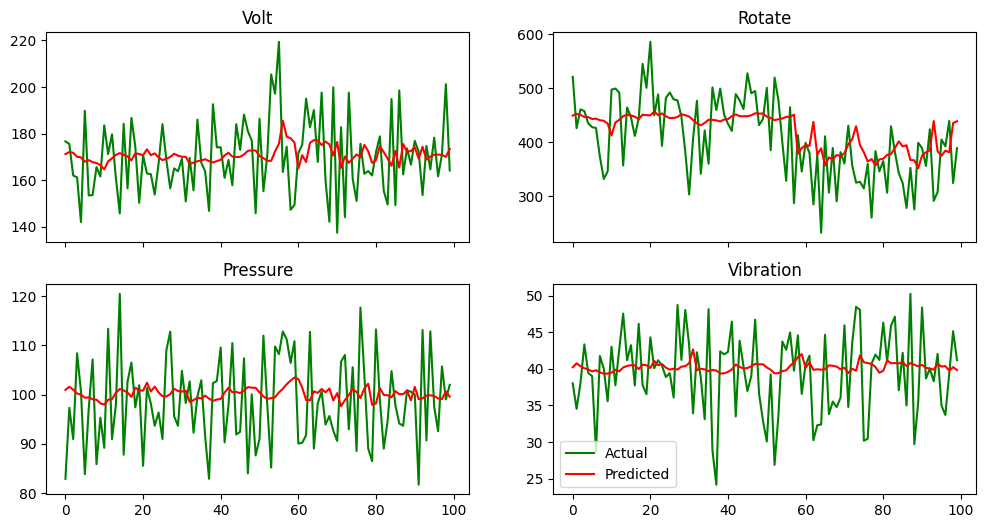

In [63]:
plot_preds(y_pred_val, y_val_seq, 100, 200)

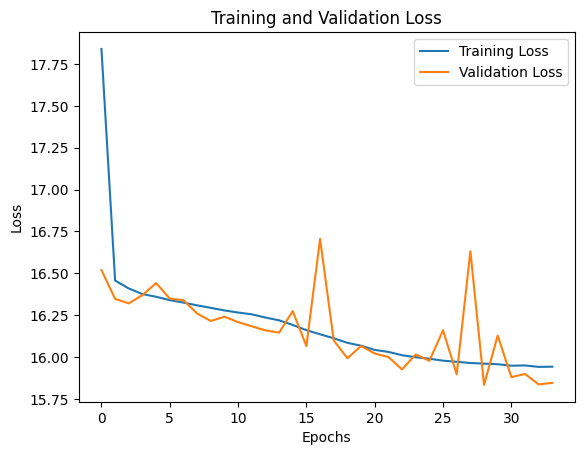

In [64]:
plt.plot(history_GRU.history['loss'], label='Training Loss')
plt.plot(history_GRU.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# LSTM

In [183]:
# LSTM model
def build_LSTM(X_train):
    shape_1 = X_train.shape[1]
    shape_2 = X_train.shape[2]
    model = Sequential()
    model.add(Input(shape=(shape_1, shape_2)))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4))
    
    return model

In [184]:
# Build LSTM
model_LSTM = build_LSTM(X_train_seq)
# model_LSTM.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 4, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,156 (207.64 KB)

 Trainable params: 53,156 (207.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile and fit LSTM
model_LSTM.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(), metrics=[MeanSquaredError()])

In [186]:
history_LSTM = model_LSTM.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), verbose=1, epochs=3)

Epoch 1/3


18207/18207 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - loss: 19.0346 - mean_squared_error: 1503.8301 - val_loss: 16.3605 - val_mean_squared_error: 781.1875
Epoch 2/3
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step - loss: 16.4048 - mean_squared_error: 790.8481 - val_loss: 16.8032 - val_mean_squared_error: 838.0816
Epoch 3/3
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - loss: 16.1557 - mean_squared_error: 771.7475 - val_loss: 15.9244 - val_mean_squared_error: 749.0342


In [187]:
# Save LSTM model
model_LSTM.save('../models/model_saves/model_LSTM.keras')

In [188]:
y_pred_val_LSTM = model_LSTM.predict(X_val_seq)

4575/4575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


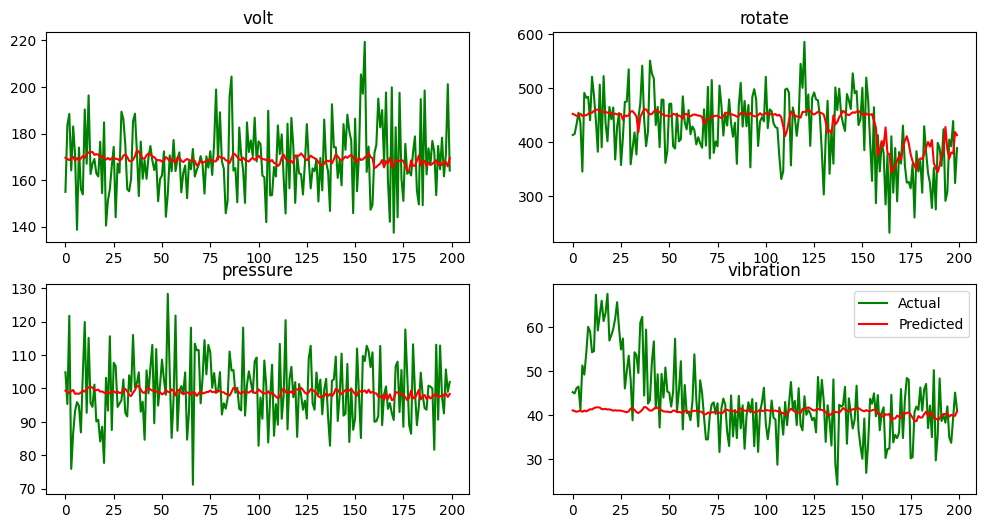

In [191]:
# Plot predictions and actual values
plot_preds(y_pred_val_LSTM, y_val_seq, 100, 200)

In [ ]:
plt.plot(history_LSTM.history['loss'], label='Training Loss')
plt.plot(history_LSTM.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Training GRU on full training data (including validation data)

In [25]:
full_train_df = df[:start_test]
full_train_df = full_train_df.sort_values(by=['machineID', 'datetime']).reset_index().drop(columns='index')


In [31]:
X_full_train_seq, y_full_train_seq = create_sequences(full_train_df, seq_length)

In [37]:
X_full_train_seq = tf.convert_to_tensor(X_full_train_seq, dtype=tf.float32)

In [38]:
model_GRU = build_GRU(X_full_train_seq) 

In [39]:
# Compile and fit GRU
model_GRU.compile(optimizer=Adam(learning_rate=0.0002), loss=Huber(), metrics=[MeanSquaredError()])

In [40]:
history_GRU = model_GRU.fit(X_full_train_seq, y_full_train_seq, verbose=1, epochs=50, callbacks=[early_stopping, cp]) 

Epoch 1/50


22782/22782 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 23.2824 - mean_squared_error: 2951.0229
Epoch 2/50
   44/22782 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - loss: 16.7724 - mean_squared_error: 815.8576 

c:\Users\jakob\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_squared_error
  current = self.get_monitor_value(logs)
c:\Users\jakob\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


22782/22782 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - loss: 16.4487 - mean_squared_error: 795.0515
Epoch 3/50
22782/22782 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - loss: 16.4016 - mean_squared_error: 793.2230
Epoch 4/50
22782/22782 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - loss: 16.3517 - mean_squared_error: 788.9453
Epoch 5/50
22782/22782 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - loss: 16.3189 - mean_squared_error: 786.6395
Epoch 6/50
22782/22782 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 16.3190 - mean_squared_error: 787.8225
Epoch 7/50
22782/22782 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 16.2916 - mean_squared_error: 784.5345
Epoch 8/50
22782/22782 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 16.2752 - mean_squared_error: 783.7269
Epoch 9/50
22782/22782 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - loss: 16.2434 - mean_squared_error: 781.1562
Epoch 10/50
22782/22782 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - loss: 16.2318 - mean_squared_error: 780.4438
Epoch 11/50
22782/22782 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - loss: 16.1931 

In [ ]:
y_pred_test = model_GRU.predict(X_test_seq)  

In [ ]:
plot_preds(y_pred_test, y_test_seq, 100, 200)

In [ ]:
plt.plot(history_GRU.history['loss'], label='Training Loss')
plt.plot(history_GRU.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()